In [1]:
import numpy as np
seed_ = 20200218
np.random.seed(seed_)

import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
color_palette = sns.color_palette("muted")
sns.set_palette(color_palette)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.callbacks import EarlyStopping

from PIL import Image
from PIL import ImageOps

In [2]:
df = pd.read_csv("./data/train.csv")

In [3]:
X = df.iloc[:, 1:]
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y = df['label']
y.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [5]:
X.values.shape

(42000, 784)

In [6]:
# reshape (num_img, h, w, num_channel)
X_ = X.values.reshape(X.values.shape[0], 28, 28, 1)

# normalization
X_ = X_/255

In [7]:
onehot_y  = pd.get_dummies(y).values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_, onehot_y, test_size=0.3, random_state=seed_)

In [9]:
X_train.shape, X_test.shape

((29400, 28, 28, 1), (12600, 28, 28, 1))

In [10]:
y_train.shape, y_test.shape

((29400, 10), (12600, 10))

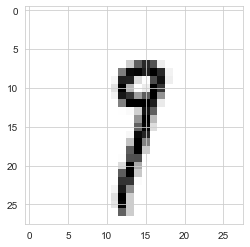

In [11]:
plt.imshow(X_train[0][:, :, 0], cmap="Greys")

# 
## model

[keras conv2d](https://keras.io/api/layers/convolution_layers/convolution2d/)

- ส่วนมากจะใช้ conv+maxpool
- conv kernelsize เป็นเลขคี่

In [12]:
model = Sequential()

# first hidden layer
model.add(Conv2D(5, input_shape=(28, 28, 1), kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

# hidden layer
model.add(Conv2D(10, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

# FC / output layer
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 5)         50        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 10)        460       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 10)          0         
_________________________________________________________________
flatten (Flatten)            (None, 490)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                4910      
Total params: 5,420
Trainable params: 5,420
Non-trainable params: 0
______________________________________________________

In [13]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-13-ddc73e5297f1>:1) ]] [Op:__inference_train_function_730]

Function call stack:
train_function


In [ ]:
predicted_ytrain = model.predict(X_train)
predicted_ytest = model.predict(X_test)

In [ ]:
predicted_ytrain.shape

In [ ]:
model.predict_classes(X_train)

In [ ]:
np.argmax(predicted_ytrain, axis=1)

# 
## Model Evaluation

In [ ]:
epoch_x = np.arange(1, len(history.history['accuracy'])+1)

plt.figure(figsize=(8, 4), dpi=100)
sns.lineplot(epoch_x, history.history['accuracy'], label='train')
sns.lineplot(epoch_x, history.history['val_accuracy'], label='validation')
plt.title('accuracy')
plt.xticks(epoch_x)
plt.show()

plt.figure(figsize=(8, 4), dpi=100)
sns.lineplot(epoch_x, history.history['loss'], label='train')
sns.lineplot(epoch_x, history.history['val_loss'], label='validation')
plt.title('loss')
plt.xticks(epoch_x)
plt.show()

In [ ]:
confusion_mat = confusion_matrix(np.argmax(y_train, axis=1), model.predict_classes(X_train))

plt.figure(figsize=(8, 8), dpi=100)
sns.heatmap(confusion_mat, square=True, annot=True, cmap='RdBu', fmt="d")
plt.xlabel('actual y')
plt.ylabel('predicted y')
plt.show()

# 
## Visaulize Result

In [ ]:
train_df = pd.DataFrame(X_train.squeeze().reshape(X_train.squeeze().shape[0], 28*28))
train_df['label'] = np.argmax(y_train, axis=1)

test_df = pd.DataFrame(X_test.squeeze().reshape(X_test.squeeze().shape[0], 28*28))
test_df['label'] = np.argmax(y_test, axis=1)

In [ ]:
train_df['predicted_label'] = np.argmax(predicted_ytrain, axis=1)
test_df['predicted_label'] = np.argmax(predicted_ytest, axis=1)

In [ ]:
train_df[train_df['label'] != train_df['predicted_label']]

In [ ]:
def plot_img(img_px, actual_label, predicted_label):
    fig = plt.figure(figsize=(5, 5), dpi=100)
    plt.imshow(img_px, cmap='Greys')
    
    plt.title(f"{actual_label=:.0f}, {predicted_label=:.0f}")
    plt.show()

In [ ]:
plot_img(train_df.iloc[0, 0:784].values.reshape(28, 28), train_df.iloc[0]['label'], train_df.iloc[0]['predicted_label'])

In [ ]:
for digit in range(0, 10):
    true_positive = train_df[(train_df['label'] == train_df['predicted_label']) & (train_df['label'] == digit)].sample(5)
    
    fig, axes = plt.subplots(1, 5, dpi=100, figsize=(10, 2))
    fig.subplots_adjust(top=0.8)
    for i, ax in enumerate(axes):
        ax.imshow(true_positive.iloc[i, 0:784].values.reshape(28, 28), cmap='Greys')
        ax.set_title(f"predicted={true_positive.iloc[i]['predicted_label']:.0f}")
        plt.suptitle(digit)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
for digit in range(0, 10):
    err = train_df[(train_df['label'] != train_df['predicted_label']) & (train_df['label'] == digit)].sample(5, replace=True)
    
    fig, axes = plt.subplots(1, 5, dpi=100, figsize=(10, 2))
    fig.subplots_adjust(top=0.8)
    for i, ax in enumerate(axes):
        ax.imshow(err.iloc[i, 0:784].values.reshape(28, 28), cmap='Greys')
        ax.set_title(f"predicted={err.iloc[i]['predicted_label']:.0f}")
        plt.suptitle(digit)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
for digit in range(0, 10):
    err = test_df[(test_df['label'] != test_df['predicted_label']) & (test_df['label'] == digit)].sample(5, replace=True)
    
    fig, axes = plt.subplots(1, 5, dpi=100, figsize=(10, 2))
    fig.subplots_adjust(top=0.8)
    for i, ax in enumerate(axes):
        ax.imshow(err.iloc[i, 0:784].values.reshape(28, 28), cmap='Greys')
        ax.set_title(f"predicted={err.iloc[i]['predicted_label']:.0f}")
        plt.suptitle(digit)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# 
## predict my handwritting

In [ ]:
my_images = [np.array(ImageOps.invert(Image.open(f'./my_handwrite/{i}.png').convert('L'))) for i in range(0, 10)]
my_images = np.array(my_images) / 255

In [ ]:
my_images.shape

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10), dpi=200)

predicted_my_hadwrite = model.predict_classes(my_images.reshape(10, 28, 28, 1))

for digit in range(0, 10):
    axes[digit].imshow(my_images[digit], cmap='Greys')
    axes[digit].set_title(predicted_my_hadwrite[digit])
    axes[digit].get_yaxis().set_visible(False)
    axes[digit].get_xaxis().set_visible(False)